<img src="img/dslogo.png" alt="title" align="right">

# ABACO: Automatic Bed Assistance based on Continuous Optimization.

## Influencia de características en la calidad del sueño: Aprendizaje supervisado

#### 11 de septiembre de 2020

En este informe se estudia la **relación que tienen las características de los usuarios y las configuraciones que tienen en sus colchones con su calidad de sueño**, medida a través de la variable sqr. 

Las características sobre el usuario que se han considerado para este análisis son:
* Sexo: Hombre o mujer.
* Posición: Posición de dormir lateral o supina.
* Índice de Masa Corporal (IMC): a través de la altura y del peso del usuario, se calcula su IMC y se categoriza en tres niveles:
    * IMC<25: Peso normal
    * IMC<=25 e IMC< 30: Sobrepeso
    * IMC>=30; Obesidad
    
Así mismo, se estudia la influencia de la presión configurada en cada uno de los seis tubos del colchón en la calidad el sueño obtenida. 


Se persigue buscar cuál de dichas características técnicas o del usuario están mas fuertemente ligadas con valores altos del SQR altos, estudiadas tanto de forma independiente y como con  interacción entre ellas.  Para esta tarea se emplean **técnicas clásicas del análisis estadístico así como técnicas de Aprendizaje Máquina Explicable**.

El informe se estructura como sigue. En primer lugar se realiza un **análisis descriptivo univariante** donde se presentan los estadísticos principales de todas las variables que se consideran en este informe. Esto es, del sqr, de las características sobre el usuario y de las configuraciones de las presiones en cada uno de los tubos.

En segundo lugar se presenta un **análisis bivariante** donde a través de las técnicas clásicas del análisis estadístico se cruza la variable SQR con las características del usuario y las configuraciones de los colchones. 

Cruzando las categorías de las variables Sexo, Posición e IMC, se obtienen 12 distintos perfiles de usuarios. Así, en un tercer estadio del informe, se lleva a cabo un **análisis de datos exhaustivo** en el que se estudia la distribución del SQR **dentro de los 12 tipos de perfiles de usuarios** que se tienen y en sus configuraciones de presiones.   

Por último, a través de **técnicas de Aprendizaje Máquina Explicable**, se estudian el **tubo que resulta más importantes en la configuración de las presiones para explicar el valor del SQR** y el que resulta menos importante. Este estudio se realiza dentro de cada uno de los 12 perfiles de usuario. Esto permitirá guiar sobre qué tubos conviene realizar cambios de presiones en la configuración de los colchones para cada tipo de usuario, a la hora de buscar una mejora del SQR. Para el tubo que resulta más importante a la hora de explicar el SQR, se presenta también la **mejora que se produce en el SQR al configurar en dicho tubo con la presión que devuelve mayores valores del SQR**.


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Cargamos las librerías necesarias
from sklearn import preprocessing
from statistics import mode
from scipy import stats
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestRegressor
import scipy.cluster.hierarchy as sch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
pd.options.display.max_rows = 180

In [4]:
# Cargamos datos con SQR
perfiles_sqr = pd.read_parquet('../data/processed/perfiles_sqr_filtrado.parquet')
perfiles_sqr.reset_index(drop=True, inplace=True) # reseteamos el índice

In [5]:
# perfiles_sqr.head()
perfiles_sqr['IMC'] = perfiles_sqr['peso'] / (perfiles_sqr['altura']/100)**2
perfiles_sqr['IMC_cat'] = pd.cut(perfiles_sqr['IMC'], bins=[0, 25, 30, 50],
                                include_lowest=True,labels=['Normal', 'Overweight', 'Obese'])
# tubos
for i in range(6):
    perfiles_sqr[f'PresPos{i+1}'] = perfiles_sqr.presiones.apply(lambda x: x[i])

In [6]:
sns.set_style('dark')

Contenidos:
* [Análisis univariante](#100)
    * [SQR](#101)
    * [Sexo](#102)
    * [Posición](#103)
    * [Altura](#104)
    * [Peso](#105)
    * [IMC](#106)
    * [Presiones](#107)
* [Análisis bivariante](#200)
    * [Sexo con SQR](#201)
    * [Posición con SQR](#202)
    * [IMC con SQR](#203)
    * [Tubos con SQR](#204)
* [Análisis de SQR por categorías](#300)
    * [Male Lateral Normal (MLN)](#1)
    * [Male Lateral Overweight (MLO)](#2)
    * [Male Lateral Obese (MLOb)](#3)
    * [Male Supine Normal (MSN)](#4)
    * [Male Supine Overweight (MSO)](#5)
    * [Male Supine Obese (MSOb)](#6)
    * [Female Lateral Normal (FLN)](#7)
    * [Female Lateral Overweight (FLO)](#8)
    * [Female Lateral Obese (FLOb)](#9)
    * [Female Supine Normal (FSN)](#10)
    * [Female Supine Overweight (FSO)](#11)
    * [Female Supine Obese (FSOb)](#12)
    


<a id="100"></a>
## Análisis univariante

<a id="101"></a>
### SQR

El SQR está centrado en torno al 70-75% como refleja el siguiente histograma y sus valores de media (72.14%) y de mediana (74.26%). El valor del cuantil 9 es 50.76%, es decir, sólo un 9% de los individuos obtienen un SQR menor del 50%. El primer cuartil (25) es 63.44, lo que implica que un 75% de los usuarios logran una calidad del sueño superior al 63%.

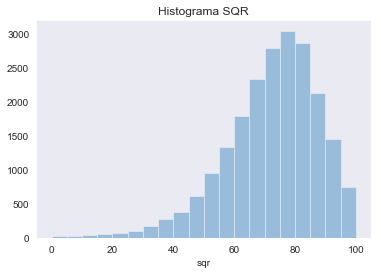

In [7]:
sns.distplot(perfiles_sqr["sqr"], bins=20,kde = False,hist=True)
plt.title("Histograma SQR")
plt.show();

In [8]:
sqr = pd.DataFrame(perfiles_sqr["sqr"].describe()).round(2).T
sqr.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns', inplace=True)
sqr['frecuencia absoluta'] = sqr['frecuencia absoluta'].astype(int)

In [9]:
display(sqr)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max
sqr,21219,72.14,15.41,0.02,63.45,74.26,83.09,99.86


<a id="102"></a>
### Sexo

Entre los usuarios el número de hombres es ligeramente superior al de mujeres (55% vs 45%) pero está bastante equilibrado.

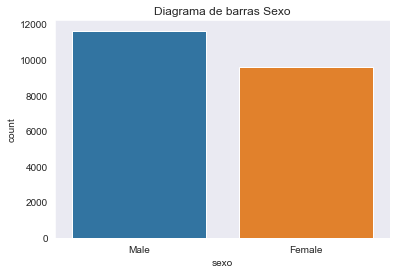

In [10]:
sns.countplot(x='sexo', data=perfiles_sqr)
plt.title("Diagrama de barras Sexo")
plt.show();

In [11]:
display(pd.DataFrame({'frecuencia absoluta': perfiles_sqr["sexo"].value_counts(), 'frecuencia relativa': round(perfiles_sqr["sexo"].value_counts()/21219,2)}))

,frecuencia absoluta,frecuencia relativa
Male,11617,0.55
Female,9602,0.45


<a id="103"></a>
### Posición

El 71% de los usuarios duerme en posición lateral frente al 29% que duerme en posición supine.

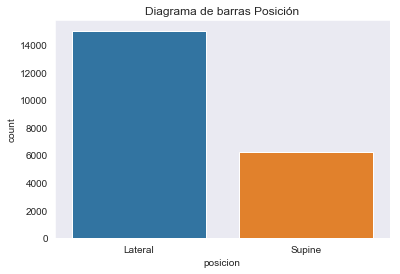

In [12]:
sns.countplot(x='posicion', data=perfiles_sqr)
plt.title("Diagrama de barras Posición")
plt.show();

In [13]:
display(pd.DataFrame({'frecuencia absoluta': perfiles_sqr["posicion"].value_counts(), 'frecuencia relativa': round(perfiles_sqr["posicion"].value_counts()/21219,2)}))

,frecuencia absoluta,frecuencia relativa
Lateral,15013,0.71
Supine,6206,0.29


<a id="104"></a>
### Altura

La altura muestra una distribución simétrica centrada en 170 cm.

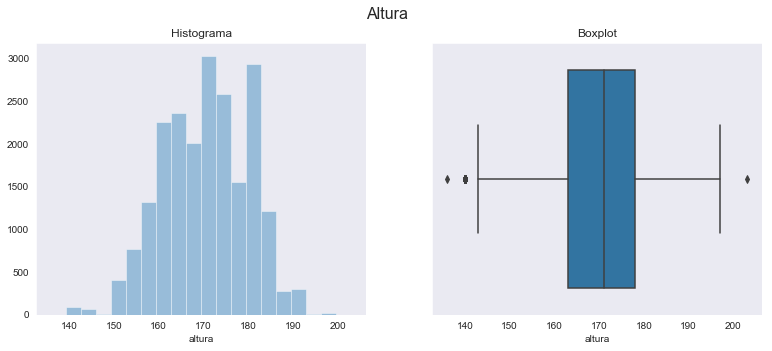

In [14]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False,figsize=(13,5))
sns.distplot(perfiles_sqr["altura"], bins=20,kde = False,hist=True, ax = ax1).set_title('Histograma')
sns.boxplot(perfiles_sqr["altura"], ax = ax2).set_title('Boxplot')
fig.suptitle('Altura', fontsize=16)
plt.show();

In [15]:
altura = pd.DataFrame(perfiles_sqr["sqr"].describe()).round(2).T
altura.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns', inplace=True)
altura['frecuencia absoluta'] = altura['frecuencia absoluta'].astype(int)

In [16]:
display(altura)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max
sqr,21219,72.14,15.41,0.02,63.45,74.26,83.09,99.86


<a id="105"></a>
### Peso

El peso medio de los usuarios es de unos 74 kg. Se encuentran algunos valores atípicos a partir de los 120 kg.

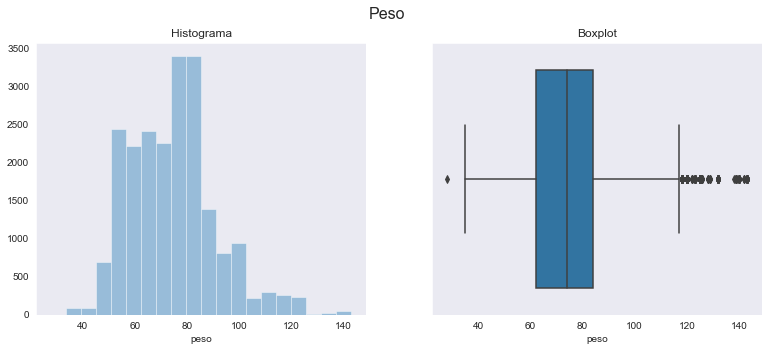

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2, sharex=False, sharey=False,figsize=(13,5))
sns.distplot(perfiles_sqr["peso"], bins=20,kde = False,hist=True, ax = ax1).set_title('Histograma')
sns.boxplot(perfiles_sqr["peso"], ax = ax2).set_title('Boxplot')
fig.suptitle('Peso', fontsize=16)
plt.show();

In [18]:
peso = pd.DataFrame(perfiles_sqr["sqr"].describe()).round(2).T
peso.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns', inplace=True)
peso['frecuencia absoluta'] = peso['frecuencia absoluta'].astype(int)

In [19]:
display(peso)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max
sqr,21219,72.14,15.41,0.02,63.45,74.26,83.09,99.86


<a id="106"></a>
### IMC

Se calcula el IMC (Índice de Masa Corporal) a partir de la altura y el peso. Mediante la ecuación:

$$IMC = peso (kg)/ estatura^2 (m^2) $$

Se categoriza dicha variable en 3 categorías:
* 'Normal' si IMC < 25
* 'Overweight' si IMC está entre 25 y 30
* 'Obese' si el IMC es superior a 30

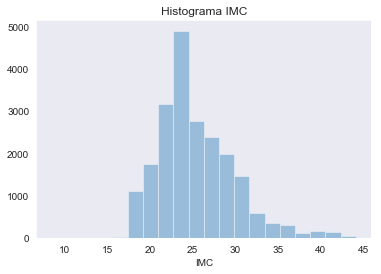

In [20]:
sns.distplot(perfiles_sqr["IMC"], bins=20,kde = False,hist=True)
plt.title("Histograma IMC")
plt.show();

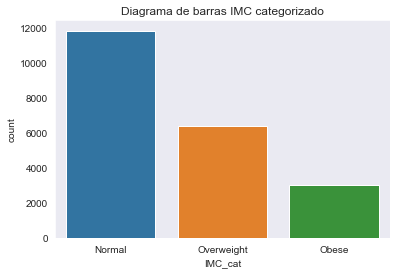

In [21]:
sns.countplot(x='IMC_cat', data=perfiles_sqr)
plt.title("Diagrama de barras IMC categorizado")
plt.show();

In [22]:
display(pd.DataFrame({'frecuencia absoluta': perfiles_sqr["IMC_cat"].value_counts(), 'frecuencia relativa': round(perfiles_sqr["IMC_cat"].value_counts()/21219,2)}))

,frecuencia absoluta,frecuencia relativa
Normal,11805,0.56
Overweight,6393,0.30
Obese,3021,0.14


<a id="107"></a>
### Presiones

El siguiente gráfico muestra la frecuencia de uso de las 6 presiones posibles en cada uno de los 6 tubos. En el tubo 1 son más usadas las presiones bajas (0 y 1) al igual que en el tubo 6 (1 y 2) aunque en este la presión seleccionada es mayor. Por otro lado, en los tubos 2, 3, 4 y 5 las presiones más usadas son más altas (principalmente 2 y 3).

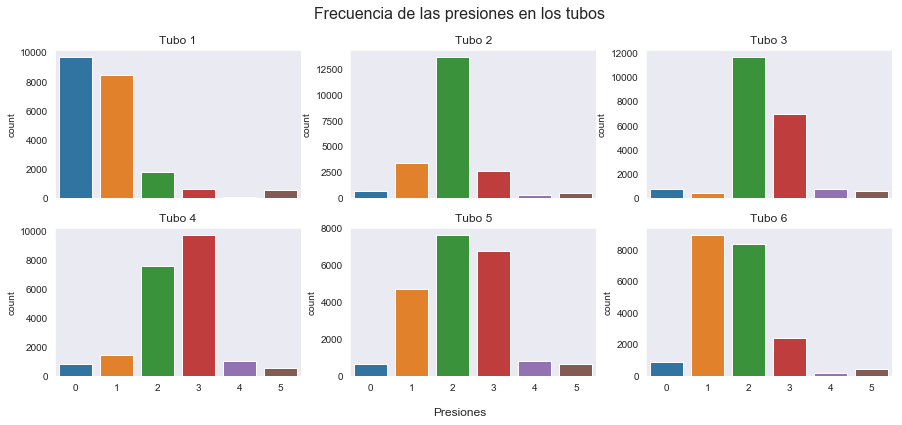

In [23]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.countplot(x='PresPos1', data=perfiles_sqr,ax=axs[0, 0]).set(title = 'Tubo 1',xlabel=None)
sns.countplot(x='PresPos2', data=perfiles_sqr,ax=axs[0, 1]).set(title = 'Tubo 2',xlabel=None)
sns.countplot(x='PresPos3', data=perfiles_sqr,ax=axs[0, 2]).set(title = 'Tubo 3',xlabel=None)
sns.countplot(x='PresPos4', data=perfiles_sqr,ax=axs[1, 0]).set(title = 'Tubo 4',xlabel=None)
sns.countplot(x='PresPos5', data=perfiles_sqr,ax=axs[1, 1]).set(title = 'Tubo 5',xlabel=None)
sns.countplot(x='PresPos6', data=perfiles_sqr,ax=axs[1, 2]).set(title = 'Tubo 6',xlabel=None)
fig.text(0.5, 0.04, 'Presiones', va='center', ha='center', fontsize=12)
fig.suptitle('Frecuencia de las presiones en los tubos', fontsize=16)
plt.show();

<a id="200"></a>
## Análisis bivariante

<a id="201"></a>
### Sexo con SQR

El SQR obtenido por las mujeres es ligeramente superior al de los hombres (media de 73 frente a 71.4).

In [24]:
sexo_sqr = perfiles_sqr.groupby('sexo').describe().loc[:, 'sqr'].rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
sexo_sqr['frecuencia absoluta'] = sexo_sqr['frecuencia absoluta'].astype(int)
sexo_sqr['frecuencia relativa'] = round(sexo_sqr['frecuencia absoluta']/21219, 2)
sexo_sqr = sexo_sqr[['frecuencia absoluta', 'frecuencia relativa', 'media', 'desviación', 'min', '25%', '50%','75%', 'max']] 

In [25]:
display(sexo_sqr)

,frecuencia absoluta,frecuencia relativa,media,desviación,min,25%,50%,75%,max
sexo,,,,,,,,,
Female,9602,0.45,73.031235,14.280687,0.018056,64.770960,74.524908,83.150952,99.581944
Male,11617,0.55,71.404368,16.253099,0.548611,62.268319,74.079504,83.023109,99.859722


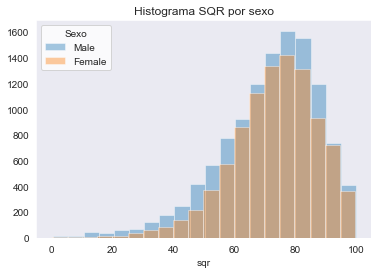

In [26]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['sexo']=="Male",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['sexo']=="Female",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR por sexo')
plt.legend(title='Sexo', loc='upper left', labels=['Male', 'Female'],facecolor = 'white')
plt.show();

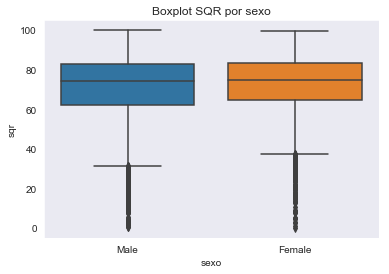

In [27]:
sns.boxplot(x="sexo", y="sqr",data=perfiles_sqr).set_title("Boxplot SQR por sexo")
plt.show();

<a id="202"></a>
### Posición con SQR

In [28]:
posicion_sqr = perfiles_sqr.groupby('posicion').describe().loc[:, 'sqr'].rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
posicion_sqr['frecuencia absoluta'] = posicion_sqr['frecuencia absoluta'].astype(int)
posicion_sqr['frecuencia relativa'] = round(posicion_sqr['frecuencia absoluta']/21219, 2)
posicion_sqr = posicion_sqr[['frecuencia absoluta', 'frecuencia relativa', 'media', 'desviación', 'min', '25%', '50%','75%', 'max']] 

In [29]:
display(posicion_sqr)

,frecuencia absoluta,frecuencia relativa,media,desviación,min,25%,50%,75%,max
posicion,,,,,,,,,
Lateral,15013,0.71,72.607845,15.312401,0.548611,64.112296,74.783839,83.474616,99.720833
Supine,6206,0.29,71.010132,15.596523,0.018056,61.830082,72.988868,81.998622,99.859722


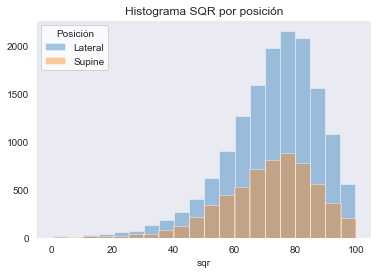

In [30]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['posicion']=="Lateral",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['posicion']=="Supine",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR por posición')
plt.legend(title='Posición', loc='upper left', labels=['Lateral', 'Supine'],facecolor = 'white')
plt.show();

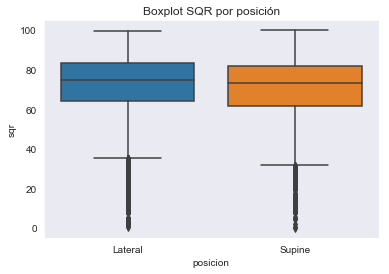

In [31]:
sns.boxplot(x="posicion", y="sqr",data=perfiles_sqr).set_title("Boxplot SQR por posición")
plt.show();

<a id="203"></a>
### IMC con SQR

Las personas con Obese tienen un SQR medio menor que el de las personas con peso normal y con peso bajo.

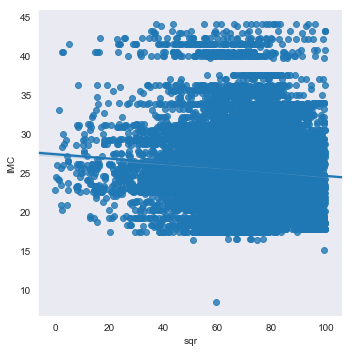

In [32]:
sns.lmplot(x="sqr", y="IMC", data=perfiles_sqr)
plt.show();

In [33]:
IMC_cat_sqr = perfiles_sqr.groupby('IMC_cat').describe().loc[:, 'sqr'].rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
IMC_cat_sqr['frecuencia absoluta'] = IMC_cat_sqr['frecuencia absoluta'].astype(int)
IMC_cat_sqr['frecuencia relativa'] = round(IMC_cat_sqr['frecuencia absoluta']/21219, 2)
IMC_cat_sqr = posicion_sqr[['frecuencia absoluta', 'frecuencia relativa', 'media', 'desviación', 'min', '25%', '50%','75%', 'max']] 

In [34]:
display(IMC_cat_sqr)

,frecuencia absoluta,frecuencia relativa,media,desviación,min,25%,50%,75%,max
posicion,,,,,,,,,
Lateral,15013,0.71,72.607845,15.312401,0.548611,64.112296,74.783839,83.474616,99.720833
Supine,6206,0.29,71.010132,15.596523,0.018056,61.830082,72.988868,81.998622,99.859722


In [35]:
from scipy.stats import f_oneway
a = perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Normal",'sqr']
b = perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Overweight",'sqr']
c = perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Obese",'sqr']

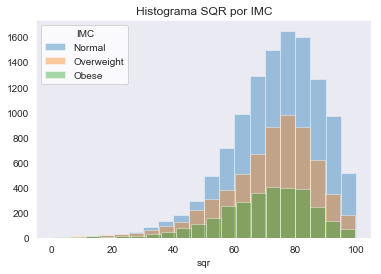

In [36]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Normal",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Overweight",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['IMC_cat']=="Obese",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR por IMC')
plt.legend(title='IMC', loc='upper left', labels=['Normal', 'Overweight', 'Obese'],facecolor = 'white')
plt.show();

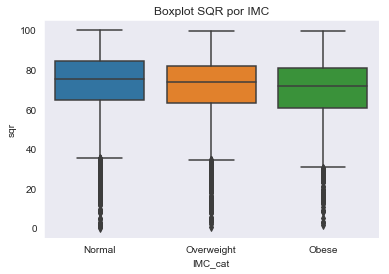

In [37]:
sns.boxplot(x="IMC_cat", y="sqr",data=perfiles_sqr).set_title("Boxplot SQR por IMC")
plt.show();

<a id="204"></a>
### Tubos con SQR

A continuación se muestra la distribución del SQR en función de la presión utilizada en cada uno de los tubos. Nótese que las presiones 4 y 5 son las menos utilizadas y, por tanto, su tamaño muestral es menor. Esto puede causar que sean los histogramas más variables.

#### Tubo 1

In [38]:
PresPos1_sqr = perfiles_sqr.groupby('PresPos1').describe().loc[:, 'sqr'].rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos1_sqr['frecuencia absoluta'] = PresPos1_sqr['frecuencia absoluta'].astype(int)
PresPos1_sqr['frecuencia relativa'] = round(PresPos1_sqr['frecuencia absoluta']/21219, 2)
PresPos1_sqr = PresPos1_sqr[['frecuencia absoluta', 'frecuencia relativa', 'media', 'desviación', 'min', '25%', '50%','75%', 'max']] 

In [39]:
display(PresPos1_sqr)

,frecuencia absoluta,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos1,,,,,,,,,
0,9684,0.46,72.601943,15.090361,0.548611,64.270281,74.681732,83.310503,99.720833
1,8464,0.40,71.755330,15.535917,0.018056,62.814994,73.752242,82.967043,99.859722
2,1791,0.08,70.594354,16.243762,1.523611,61.544880,73.568583,81.721241,99.581944
3,628,0.03,74.177582,14.898699,5.200000,66.256986,75.376547,83.838817,99.581944
4,100,0.00,75.105263,14.771614,35.393210,66.305243,76.386425,85.815428,99.581944
5,552,0.03,72.115225,16.422189,7.991667,63.274859,74.684639,84.087934,99.566667


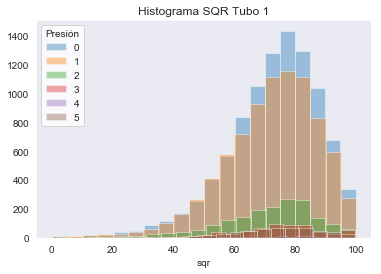

In [40]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 1')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show();

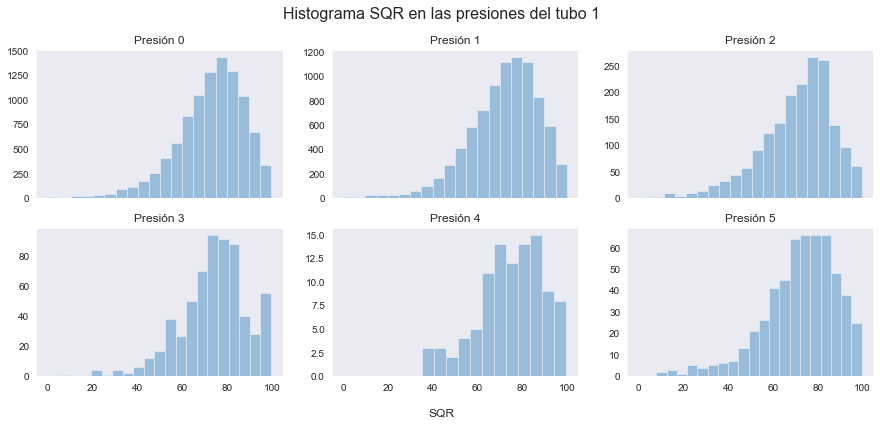

In [41]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="4",'sqr'], bins=12,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos1']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 1', fontsize=16)
plt.show();

#### Tubo 2

In [42]:
PresPos2_sqr = perfiles_sqr.groupby('PresPos2').describe().loc[:, 'sqr'].rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos2_sqr['frecuencia absoluta'] = PresPos2_sqr['frecuencia absoluta'].astype(int)
PresPos2_sqr['frecuencia relativa'] = round(PresPos2_sqr['frecuencia absoluta']/21219, 2)
PresPos2_sqr = PresPos1_sqr[['frecuencia absoluta', 'frecuencia relativa', 'media', 'desviación', 'min', '25%', '50%','75%', 'max']] 

In [43]:
display(PresPos2_sqr)

,frecuencia absoluta,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos1,,,,,,,,,
0,9684,0.46,72.601943,15.090361,0.548611,64.270281,74.681732,83.310503,99.720833
1,8464,0.40,71.755330,15.535917,0.018056,62.814994,73.752242,82.967043,99.859722
2,1791,0.08,70.594354,16.243762,1.523611,61.544880,73.568583,81.721241,99.581944
3,628,0.03,74.177582,14.898699,5.200000,66.256986,75.376547,83.838817,99.581944
4,100,0.00,75.105263,14.771614,35.393210,66.305243,76.386425,85.815428,99.581944
5,552,0.03,72.115225,16.422189,7.991667,63.274859,74.684639,84.087934,99.566667


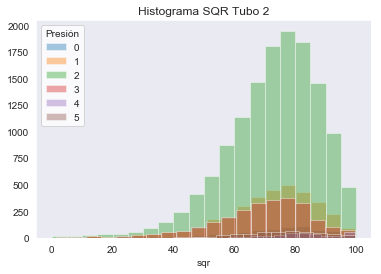

In [44]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 2')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show();

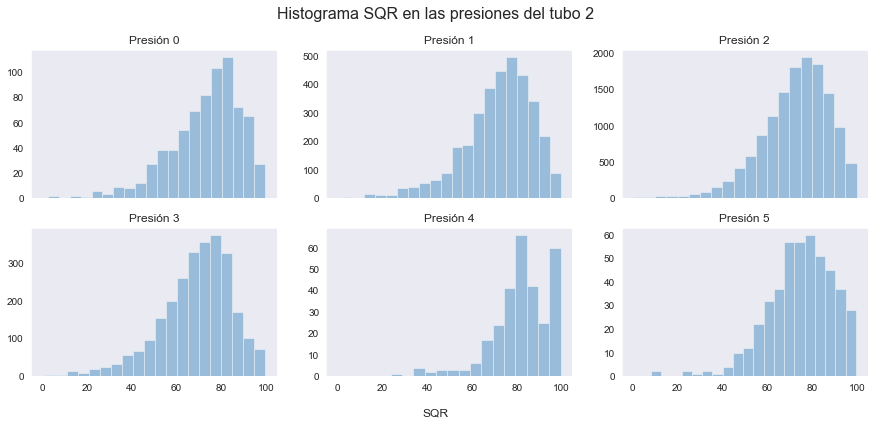

In [45]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="4",'sqr'], bins=15,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos2']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 2', fontsize=16)
plt.show();

#### Tubo 3

In [46]:
PresPos3_sqr = perfiles_sqr.groupby('PresPos3').describe().loc[:, 'sqr'].rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos3_sqr['frecuencia absoluta'] = PresPos3_sqr['frecuencia absoluta'].astype(int)
PresPos3_sqr['frecuencia relativa'] = round(PresPos3_sqr['frecuencia absoluta']/21219, 2)
PresPos3_sqr = PresPos3_sqr[['frecuencia absoluta', 'frecuencia relativa', 'media', 'desviación', 'min', '25%', '50%','75%', 'max']] 

In [47]:
display(PresPos3_sqr)

,frecuencia absoluta,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos3,,,,,,,,,
0,740,0.03,72.882226,14.659433,2.769516,65.213097,74.692387,83.187663,99.581944
1,459,0.02,66.478631,20.167444,2.743056,54.465713,69.715050,82.385228,99.336111
2,11673,0.55,71.739676,15.234670,0.018056,62.834338,73.624789,82.761567,99.859722
3,6987,0.33,73.004088,15.177913,1.523611,65.094350,75.400113,83.501000,99.581944
4,775,0.04,73.607598,16.194871,12.990278,64.839615,75.448810,83.696812,99.581944
5,585,0.03,71.386737,16.014291,5.200000,61.923027,73.170415,83.300143,99.566667


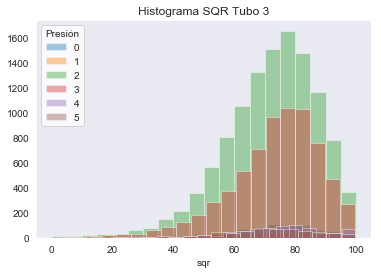

In [48]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 3')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show()

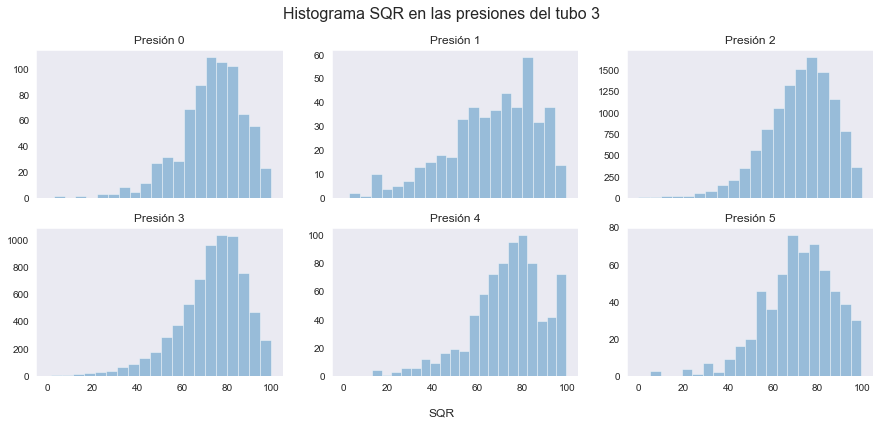

In [49]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="4",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos3']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 3', fontsize=16)
plt.show()

#### Tubo 4

In [50]:
PresPos4_sqr = perfiles_sqr.groupby('PresPos4').describe().loc[:, 'sqr'].rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos4_sqr['frecuencia absoluta'] = PresPos4_sqr['frecuencia absoluta'].astype(int)
PresPos4_sqr['frecuencia relativa'] = round(PresPos4_sqr['frecuencia absoluta']/21219, 2)
PresPos4_sqr = PresPos4_sqr[['frecuencia absoluta', 'frecuencia relativa', 'media', 'desviación', 'min', '25%', '50%','75%', 'max']] 

In [51]:
display(PresPos4_sqr)

,frecuencia absoluta,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos4,,,,,,,,,
0,808,0.04,73.149089,14.962538,2.769516,65.037798,75.479361,83.956485,99.581944
1,1441,0.07,72.010057,16.836826,2.743056,61.987203,74.009949,83.844922,99.581944
2,7570,0.36,72.424461,14.808427,0.018056,63.700868,74.246351,83.233778,99.859722
3,9751,0.46,72.310961,15.581258,0.548611,63.964697,74.655567,83.158868,99.720833
4,1072,0.05,68.393368,15.656627,12.947659,60.048492,70.226577,79.725598,99.581944
5,577,0.03,71.411545,15.869846,5.200000,62.171237,73.319806,82.993196,99.566667


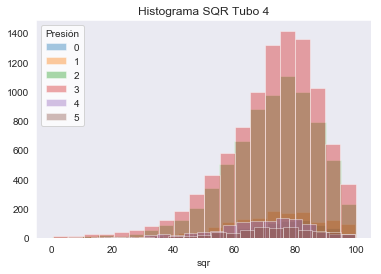

In [52]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 4')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show();

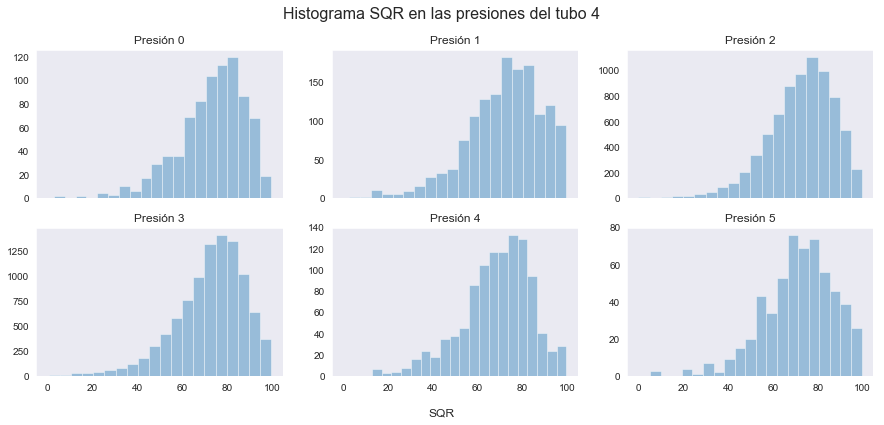

In [53]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="4",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 4', fontsize=16)
plt.show();

#### Tubo 5

In [54]:
PresPos5_sqr = perfiles_sqr.groupby('PresPos5').describe().loc[:, 'sqr'].rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos5_sqr['frecuencia absoluta'] = PresPos5_sqr['frecuencia absoluta'].astype(int)
PresPos5_sqr['frecuencia relativa'] = round(PresPos5_sqr['frecuencia absoluta']/21219, 2)
PresPos5_sqr = PresPos5_sqr[['frecuencia absoluta', 'frecuencia relativa', 'media', 'desviación', 'min', '25%', '50%','75%', 'max']] 

In [55]:
display(PresPos5_sqr)

,frecuencia absoluta,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos5,,,,,,,,,
0,665,0.03,74.623691,15.425138,2.769516,66.241118,77.892981,85.534759,99.581944
1,4687,0.22,72.362595,15.032707,0.018056,63.622169,73.931859,83.016998,99.581944
2,7630,0.36,73.071392,14.229057,0.548611,65.139217,74.949029,83.081380,99.720833
3,6772,0.32,71.419228,16.408467,0.627778,62.085353,74.161755,83.263693,99.859722
4,824,0.04,66.341276,17.010318,1.523611,57.860845,67.900212,77.299903,99.559722
5,641,0.03,71.936466,16.561297,7.991667,62.987623,74.434963,84.118401,99.581944


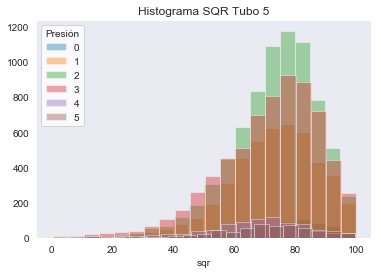

In [56]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos4']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 5')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show();

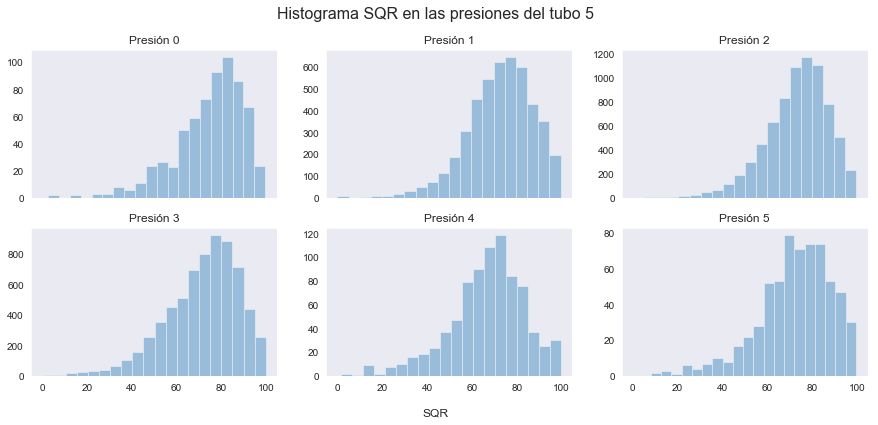

In [57]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="4",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos5']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 5', fontsize=16)
plt.show();

#### Tubo 6

In [58]:
PresPos6_sqr = perfiles_sqr.groupby('PresPos6').describe().loc[:, 'sqr'].rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
PresPos6_sqr['frecuencia absoluta'] = PresPos6_sqr['frecuencia absoluta'].astype(int)
PresPos6_sqr['frecuencia relativa'] = round(PresPos6_sqr['frecuencia absoluta']/21219, 2)
PresPos6_sqr = PresPos6_sqr[['frecuencia absoluta', 'frecuencia relativa', 'media', 'desviación', 'min', '25%', '50%','75%', 'max']] 

In [59]:
display(PresPos6_sqr)

,frecuencia absoluta,frecuencia relativa,media,desviación,min,25%,50%,75%,max
PresPos6,,,,,,,,,
0,885,0.04,74.072956,14.524366,2.769516,65.911422,76.319321,84.258490,99.581944
1,8929,0.42,72.439487,14.311262,0.548611,64.239841,74.130864,82.511416,99.720833
2,8341,0.39,71.769776,16.267688,0.018056,62.267786,74.234814,83.658215,99.859722
3,2425,0.11,70.900409,16.757019,1.523611,62.106565,73.742055,81.996672,99.581944
4,177,0.01,74.601636,11.407603,40.709470,67.367799,73.751143,82.890637,99.559722
5,462,0.02,74.922135,14.811317,7.991667,66.925287,76.517184,85.322456,99.581944


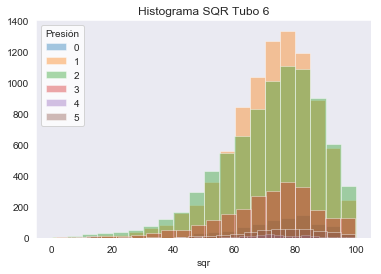

In [60]:
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="0",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="1",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="2",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="3",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="4",'sqr'], bins=20,kde = False,hist=True)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="5",'sqr'], bins=20,kde = False,hist=True).set_title('Histograma SQR Tubo 6')
plt.legend(title='Presión', loc='upper left', labels=['0', '1', '2', '3','4','5'],facecolor = 'white')
plt.show();

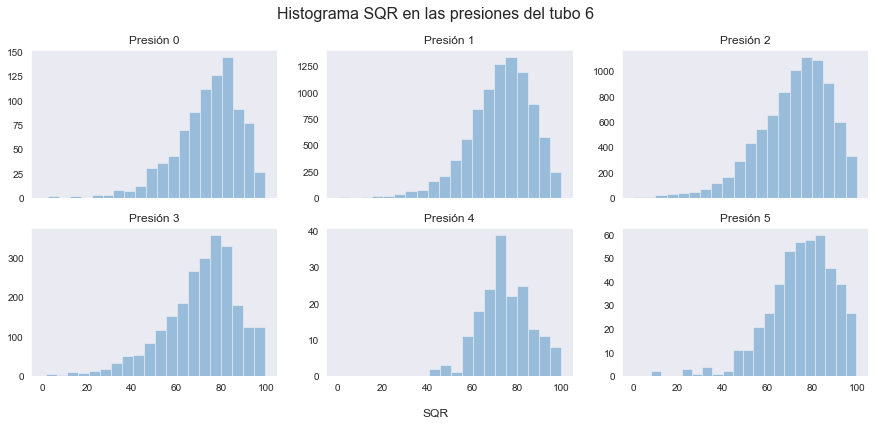

In [61]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="0",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 0]).set(title = 'Presión 0',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="1",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 1]).set(title = 'Presión 1',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="2",'sqr'], bins=20,kde = False,hist=True,ax=axs[0, 2]).set(title = 'Presión 2',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="3",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 0]).set(title = 'Presión 3',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="4",'sqr'], bins=12,kde = False,hist=True,ax=axs[1, 1]).set(title = 'Presión 4',xlabel=None)
sns.distplot(perfiles_sqr.loc[perfiles_sqr['PresPos6']=="5",'sqr'], bins=20,kde = False,hist=True,ax=axs[1, 2]).set(title = 'Presión 5',xlabel=None)
fig.text(0.5, 0.04, 'SQR', va='center', ha='center', fontsize=12)
fig.suptitle('Histograma SQR en las presiones del tubo 6', fontsize=16)
plt.show();

#### Todos los tubos

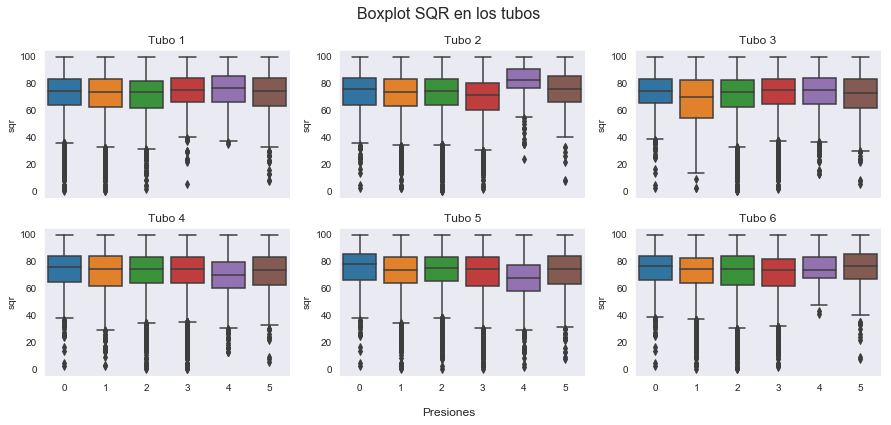

In [62]:
fig, axs = plt.subplots(2,3, sharex=True, sharey=False,figsize = (15,6))
sns.boxplot(x="PresPos1", y="sqr",data=perfiles_sqr,ax=axs[0, 0]).set(title = 'Tubo 1',xlabel=None)
sns.boxplot(x="PresPos2", y="sqr",data=perfiles_sqr,ax=axs[0, 1]).set(title = 'Tubo 2',xlabel=None)
sns.boxplot(x="PresPos3", y="sqr",data=perfiles_sqr,ax=axs[0, 2]).set(title = 'Tubo 3',xlabel=None)
sns.boxplot(x="PresPos4", y="sqr",data=perfiles_sqr,ax=axs[1, 0]).set(title = 'Tubo 4',xlabel=None)
sns.boxplot(x="PresPos5", y="sqr",data=perfiles_sqr,ax=axs[1, 1]).set(title = 'Tubo 5',xlabel=None)
sns.boxplot(x="PresPos6", y="sqr",data=perfiles_sqr,ax=axs[1, 2]).set(title = 'Tubo 6',xlabel=None)
fig.text(0.5, 0.04, 'Presiones', va='center', ha='center', fontsize=12)
fig.suptitle('Boxplot SQR en los tubos', fontsize=16)
plt.show();

<a id="300"></a>
## Análisis de SQR por categorías

A continuación se analiza la distribución del **SQR** en función de las las variables *sexo*, *posición* e *IMC*. Se obtenienen 12 categorías en función de los valores de estas variables:
* [Male Lateral Normal (MLN)](#1)
* [Male Lateral Overweight (MLO)](#2)
* [Male Lateral Obese (MLOb)](#3)
* [Male Supine Normal (MSN)](#4)
* [Male Supine Overweight (MSO)](#5)
* [Male Supine Obese (MSOb)](#6)
* [Female Lateral Normal (FLN)](#7)
* [Female Lateral Overweight (FLO)](#8)
* [Female Lateral Obese (FLOb)](#9)
* [Female Supine Normal (FSN)](#10)
* [Female Supine Overweight (FSO)](#11)
* [Female Supine Obese (FSOb)](#12)

### Box-plot

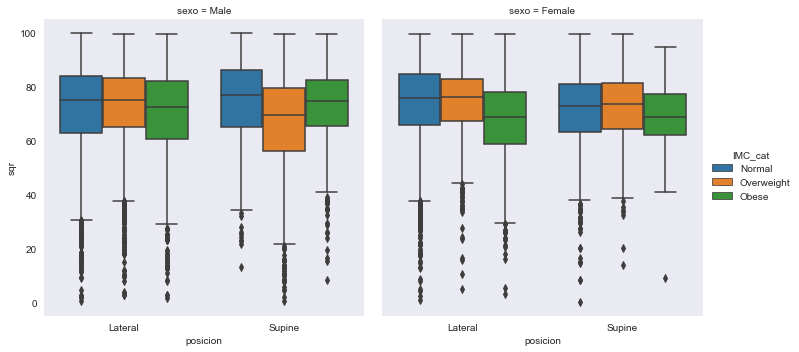

In [63]:
# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="posicion", y="sqr", hue="IMC_cat", col="sexo",
#                 capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="box", data=perfiles_sqr)
g.despine(left=True);

In [64]:
# mln
mlb = pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Normal"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
mlb['frecuencia absoluta'] = mlb['frecuencia absoluta'].astype(int)
mlb['categoría'] = 'mln'
# mlo
mln = pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Overweight"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
mln['frecuencia absoluta'] = mln['frecuencia absoluta'].astype(int)
mln['categoría'] = 'mlo'
# mlob
mls = pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Normal"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
mls['frecuencia absoluta'] = mls['frecuencia absoluta'].astype(int)
mls['categoría'] = 'mlob'
# msn
msb = pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Normal"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
msb['frecuencia absoluta'] = msb['frecuencia absoluta'].astype(int)
msb['categoría'] = 'msn'
# mso
msn = pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Overweight"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
msn['frecuencia absoluta'] = msn['frecuencia absoluta'].astype(int)
msn['categoría'] = 'mso'
# msob
mss = pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Obese"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
mss['frecuencia absoluta'] = mss['frecuencia absoluta'].astype(int)
mss['categoría'] = 'msob'
#fln
flb = pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Normal"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
flb['frecuencia absoluta'] = flb['frecuencia absoluta'].astype(int)
flb['categoría'] = 'fln'
#flo
fln = pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Overweight"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
fln['frecuencia absoluta'] = fln['frecuencia absoluta'].astype(int)
fln['categoría'] = 'flo'
#flob
fls = pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Obese"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
fls['frecuencia absoluta'] = fls['frecuencia absoluta'].astype(int)
fls['categoría'] = 'flob'
# fsn
fsb = pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Normal"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
fsb['frecuencia absoluta'] = fsb['frecuencia absoluta'].astype(int)
fsb['categoría'] = 'fsn'
# fso
fsn = pd.DataFrame(perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Normal"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
fsn['frecuencia absoluta'] = fsn['frecuencia absoluta'].astype(int)
fsn['categoría'] = 'fso'
# fsob
fss = pd.DataFrame(perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Obese"').describe().loc[:, 'sqr']).T.round(2).rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns')
fss['frecuencia absoluta'] = fss['frecuencia absoluta'].astype(int)
fss['categoría'] = 'fsob'

### Análisis descriptivo

In [65]:
total_categorias = mlb.append(mln).append(mls).append(msb).append(msn).append(mss).append(flb).append(fln).append(fls).append(fsb).append(fsn).append(fss)
display(total_categorias.set_index('categoría'))

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max
categoría,,,,,,,,
mln,3048,71.77,16.61,0.55,62.62,74.83,84.03,99.72
mlo,2919,72.51,15.32,2.78,64.85,75.02,83.12,99.58
mlob,3048,71.77,16.61,0.55,62.62,74.83,84.03,99.72
msn,1738,74.84,14.86,12.96,65.12,76.70,86.14,99.86
mso,1840,66.70,17.24,0.63,56.09,69.58,79.35,99.57
msob,586,72.29,14.74,8.40,65.34,74.72,82.44,99.37
fln,5352,74.27,14.40,1.01,65.79,75.75,84.57,99.58
flo,1385,74.32,13.00,4.82,67.33,76.09,82.73,99.58
flob,823,67.20,14.71,3.11,58.52,68.74,77.86,99.37


En el caso de los hombres cuya posición al dormir es lateral, el sqr es algo más bajo en el caso de aquellos que padecen obesidad. Sin embargo, en de los que duermen en posición supina, el sqr más bajo se produce para los que tienen sobrepso, seguidos de los que tienen obesidad. Finalmente, los hombres que duermen en posición supina y tienen peso normal, obtienen un SQR más alto que todos los demás.

En el caso de las mujeres, las que duermen en posición lateral tienen una media de SQR más alta que las que duermen en posición supina. Sin embargo, en ambas posiciones, el SQR para las mujeres con obesidad es claramente más bajo que las mujeres con peso normal o sobrepeso.

A continuación, se realiza un análisis en detalle de cada una de las 12 categorías propuestas. De cada una de ellas se proporcionan estadísticos descriptivos generales. Además, se ofrece otro estudio descriptivo de las configuraciones de presiones más significativas. Siendo estas últimas categorizadas en tres grupos:
* comunes: Las tres configuraciones con frecuencia de uso más alta.
* mejores: Las tres configuraciones con mejor SQR medio.
* peores: Las tres configuraciones con peor SQR medio.


Finalmente se realiza un análisis de la importancia individual de la presión de cada uno de los tubos. Además, se estudia la mejora del SQR en función del cambio de presión en el tubo o tubos más imporatantes de cada categoría.

In [66]:
cols = ['frecuencia absoluta', 'frecuencia relativa', 'media', 'desviación', 'min', '25%',
       '50%', '75%', 'max', 'tipo', 'presiones']

In [67]:
### Creamos cada uno de los dataframes
datos1 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Normal')]
datos2 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Overweight')]
datos3 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Obese')]
datos4 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Normal')]
datos5 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Overweight')]
datos6 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Male') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Obese')]
datos7 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Normal')]
datos8 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Overweight')]
datos9 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Lateral') & (perfiles_sqr["IMC_cat"] == 'Obese')]
datos10 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Normal')]
datos11 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Overweight')]
datos12 = perfiles_sqr[(perfiles_sqr["sexo"] == 'Female') & (perfiles_sqr["posicion"] == 'Supine') & (perfiles_sqr["IMC_cat"] == 'Obese')]

In [68]:
## Preparamos datasets para rf
X1 = datos1[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y1 = datos1['sqr']

X2 = datos2[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y2 = datos2['sqr']

X3 = datos3[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y3 = datos3['sqr']

X4 = datos4[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y4 = datos4['sqr']

X5 = datos5[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y5 = datos5['sqr']

X6 = datos6[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y6 = datos6['sqr']

X7 = datos7[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y7 = datos7['sqr']

X8 = datos8[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y8 = datos8['sqr']

X9 = datos9[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y9 = datos9['sqr']

X10 = datos10[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y10 = datos10['sqr']

X11 = datos11[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y11 = datos11['sqr']

X12 = datos12[['PresPos1','PresPos2','PresPos3','PresPos4','PresPos5','PresPos6']]
y12 = datos12['sqr']

<a id="1"></a>
### MLN

In [69]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf1 = rfr.fit(X1, y1)


#### Descriptivo general

In [70]:
display(mlb)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,3048,71.77,16.61,0.55,62.62,74.83,84.03,99.72,mln


#### Análisis de presiones

In [71]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Normal"').groupby('presiones').describe().loc[:, 'sqr']

In [72]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [73]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/mlb['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [74]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 022332                     500                 0.16  68.76   
        022321                     491                 0.16  67.59   
        122332                     412                 0.14  79.47   
mejores 355345                       3                 0.00  98.94   
        122322                       2                 0.00  94.62   
        022211                       2                 0.00  88.54   
peores  011122                      68                 0.02  43.19   
        000000                      14                 0.00  46.89   
        023332                      27                 0.01  47.03   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 022332          17.69   1.52  58.92  69.87  82.05  99.40  
        022321          14.43   0.55  59.56  69.88  77.81  99.72  
        122332          14.65  11.43  74.11  82.10  90.06  99.57  
mejores 355345           0.43  98.66  98.69  98.72  99.08  99.44  
        122322           3.81  91.93  93.27  94.62  95.96  97.31  
        022211          15.32  77.71  83.12  88.54  93.96  99.37  
peores  011122          16.31   9.39  32.42  43.78  54.99  78.73  
        000000          17.92   2.77  38.26  50.43  55.53  77.05  
        023332          14.45  18.84  38.20  46.35  56.54  77.79

#### Importancia de los tubos

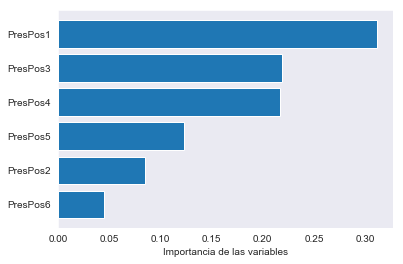

In [75]:
sorted_idx = rf1.feature_importances_.argsort()
plt.barh(X1.columns[sorted_idx], rf1.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En la categoría Male, con posición lateral y un IMC normal, si el tubo 1 se pone al valor óptimo de presión 4, la media del SQR mejora en un 12.9%.


<a id="2"></a>
### MLO

#### Descriptivo general

In [76]:
display(mln)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,2919,72.51,15.32,2.78,64.85,75.02,83.12,99.58,mlo


#### Análisis de presiones

In [77]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Overweight"').groupby('presiones').describe().loc[:, 'sqr'].sort_values(by='count', ascending=False).head(3)

In [78]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [79]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/mln['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [80]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 023321                     774                 0.27  79.01   
        123333                     557                 0.19  68.68   
        023332                     429                 0.15  71.92   
mejores 023321                     774                 0.27  79.01   
        023332                     429                 0.15  71.92   
        123333                     557                 0.19  68.68   
peores  123333                     557                 0.19  68.68   
        023332                     429                 0.15  71.92   
        023321                     774                 0.27  79.01   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 023321          11.16  22.20  72.79  80.01  86.79  99.58  
        123333          18.33   2.78  59.14  72.33  80.99  99.44  
        023332          13.86  20.60  64.84  73.33  81.93  99.58  
mejores 023321          11.16  22.20  72.79  80.01  86.79  99.58  
        023332          13.86  20.60  64.84  73.33  81.93  99.58  
        123333          18.33   2.78  59.14  72.33  80.99  99.44  
peores  123333          18.33   2.78  59.14  72.33  80.99  99.44  
        023332          13.86  20.60  64.84  73.33  81.93  99.58  
        023321          11.16  22.20  72.79  80.01  86.79  99.58

#### Importancia de los tubos

In [81]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf2 = rfr.fit(X2, y2)

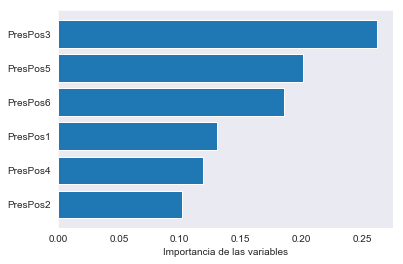

In [82]:
sorted_idx = rf2.feature_importances_.argsort()
plt.barh(X2.columns[sorted_idx], rf2.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 3 se pone al valor óptimo de presión 6, la media del SQR mejora en un 9.15%.

<a id="3"></a>
### MLOb

#### Descriptivo general

In [83]:
display(mls)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,3048,71.77,16.61,0.55,62.62,74.83,84.03,99.72,mlob


#### Análisis de presiones

In [84]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Lateral" &  IMC_cat == "Obese"').groupby('presiones').describe().loc[:, 'sqr']

In [85]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [86]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/mls['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [87]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 233343                     237                 0.08  65.35   
        233443                     233                 0.08  64.09   
        123331                     200                 0.07  78.10   
mejores 123312                       7                 0.00  98.74   
        123322                       2                 0.00  85.93   
        023321                     114                 0.04  78.53   
peores  111111                      66                 0.02  57.62   
        555555                      22                 0.01  60.12   
        123332                      35                 0.01  62.04   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 233343          19.45   1.52  54.18  70.26  79.60  99.30  
        233443          13.94  12.95  56.74  64.45  72.52  98.84  
        123331          15.74  10.71  71.35  83.45  89.33  98.31  
mejores 123312           1.01  96.62  98.61  99.29  99.33  99.37  
        123322           2.26  84.33  85.13  85.93  86.73  87.52  
        023321          10.53  46.88  72.01  80.28  86.22  94.77  
peores  111111          18.78   2.74  52.91  61.26  68.88  89.89  
        555555          16.14   7.99  53.35  60.21  67.63  85.34  
        123332          11.75  40.65  53.72  62.19  68.39  86.46

#### Importancia de los tubos

In [88]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf3 = rfr.fit(X3, y3)

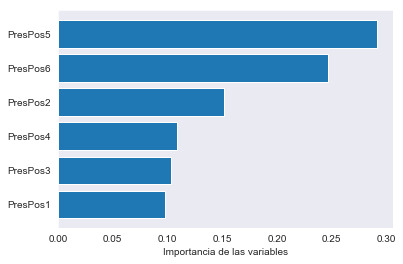

In [89]:
sorted_idx = rf3.feature_importances_.argsort()
plt.barh(X3.columns[sorted_idx], rf3.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 5 se pone al valor óptimo de presión 3, la media del SQR mejora en un 12.47%.

<a id="4"></a>
### MSN

#### Descriptivo general

In [90]:
display(msb)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,1738,74.84,14.86,12.96,65.12,76.7,86.14,99.86,msn


#### Análisis de presiones

In [91]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Normal"').groupby('presiones').describe().loc[:, 'sqr']

In [92]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [93]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/msb['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [94]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 122232                     952                 0.55  72.85   
        122332                     300                 0.17  77.05   
        122222                     144                 0.08  70.62   
mejores 344333                      91                 0.05  92.96   
        555555                      37                 0.02  87.51   
        333333                       8                 0.00  86.64   
peores  223333                       1                 0.00  55.24   
        122322                       2                 0.00  60.43   
        144332                       8                 0.00  64.32   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 122232          15.54  12.96  62.06  75.04  84.94  99.86  
        122332          12.77  22.57  69.59  79.74  86.65  99.36  
        122222          12.87  37.09  61.91  71.94  78.92  99.36  
mejores 344333           7.46  70.01  89.52  96.44  98.69  99.58  
        555555           7.35  63.77  86.08  90.06  91.95  97.57  
        333333           6.91  76.06  80.17  89.83  91.79  94.01  
peores  223333            NaN  55.24  55.24  55.24  55.24  55.24  
        122322          12.15  51.84  56.13  60.43  64.72  69.02  
        144332           7.58  54.10  60.75  65.35  66.94  78.07

#### Importancia de los tubos

In [95]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf4 = rfr.fit(X4, y4)

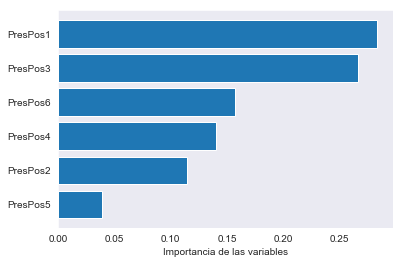

In [96]:
sorted_idx = rf4.feature_importances_.argsort()
plt.barh(X4.columns[sorted_idx], rf4.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 1 se pone al valor óptimo de presión 4, la media del SQR mejora en un 23.43%. Si el tubo 3 se pone al valor óptimo 5, la media del SQR mejora en un 21.04%.

<a id="5"></a>
### MSO

#### Descriptivo general

In [97]:
display(msn)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,1840,66.7,17.24,0.63,56.09,69.58,79.35,99.57,mso


#### Análisis de presiones

In [98]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Overweight"').groupby('presiones').describe().loc[:, 'sqr']

In [99]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [100]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/msn['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [101]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 122322                     547                 0.30  66.37   
        122332                     356                 0.19  57.80   
        123322                     173                 0.09  69.85   
mejores 555555                       3                 0.00  99.43   
        223332                      64                 0.03  81.52   
        000333                       7                 0.00  80.26   
peores  042233                       1                 0.00  39.20   
        534451                      65                 0.04  54.89   
        122332                     356                 0.19  57.80   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 122322          15.23   7.73  57.48  66.96  76.93  99.37  
        122332          19.21   0.63  46.84  57.41  71.65  99.26  
        123322          17.70  11.04  60.63  74.39  82.79  94.99  
mejores 555555           0.12  99.35  99.36  99.37  99.47  99.57  
        223332           8.99  59.64  73.33  83.32  88.50  97.08  
        000333           4.21  72.07  79.46  79.59  83.44  84.40  
peores  042233            NaN  39.20  39.20  39.20  39.20  39.20  
        534451          20.23  12.99  39.84  56.92  68.67  90.81  
        122332          19.21   0.63  46.84  57.41  71.65  99.26

#### Importancia de los tubos

In [102]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf5 = rfr.fit(X5, y5)

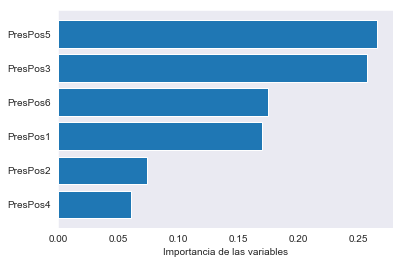

In [103]:
sorted_idx = rf5.feature_importances_.argsort()
plt.barh(X5.columns[sorted_idx], rf5.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 5 se pone al valor óptimo de presión 1, la media del SQR mejora en un 17.64%. 

<a id="6"></a>
### MSOb

#### Descriptivo general

In [104]:
display(mss)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,586,72.29,14.74,8.4,65.34,74.72,82.44,99.37,msob


#### Análisis de presiones

In [105]:
presiones_cat = perfiles_sqr.query('sexo == "Male" & posicion == "Supine" &  IMC_cat == "Obese"').groupby('presiones').describe().loc[:, 'sqr']

In [106]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [107]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/mss['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [108]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 123322                     190                 0.32  80.38   
        234443                      89                 0.15  69.79   
        233333                      72                 0.12  69.91   
mejores 123222                      15                 0.03  83.91   
        123322                     190                 0.32  80.38   
        111111                      21                 0.04  76.02   
peores  042045                       5                 0.01  42.05   
        000000                      27                 0.05  51.06   
        233332                      32                 0.05  59.14   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 123322           9.83  29.47  74.62  80.61  86.76  99.36  
        234443          16.19  15.47  61.23  70.14  82.61  99.36  
        233333          11.51  36.99  64.94  70.18  76.52  99.37  
mejores 123222           4.51  69.93  82.84  85.39  86.07  89.05  
        123322           9.83  29.47  74.62  80.61  86.76  99.36  
        111111           9.35  55.00  69.45  77.63  82.30  94.45  
peores  042045          13.02  23.84  35.11  46.07  47.24  58.01  
        000000          16.45  16.51  39.72  51.08  61.60  79.74  
        233332          17.82   8.40  49.69  59.54  71.06  85.56

#### Importancia de los tubos

In [109]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf6 = rfr.fit(X6, y6)

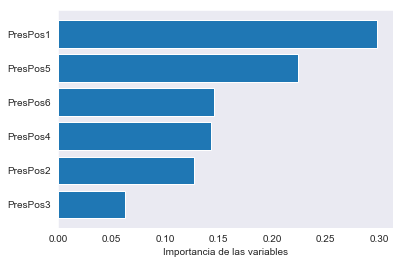

In [110]:
sorted_idx = rf6.feature_importances_.argsort()
plt.barh(X6.columns[sorted_idx], rf6.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 1 se pone al valor óptimo de presión 2, la media del SQR mejora en un 10.95%. 

<a id="7"></a>
### FLN

#### Descriptivo general

In [111]:
display(flb)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,5352,74.27,14.4,1.01,65.79,75.75,84.57,99.58,fln


#### Análisis de presiones

In [112]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Normal"').groupby('presiones').describe().loc[:, 'sqr']

In [113]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [114]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/flb['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [115]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 012211                     855                 0.16  71.81   
        022111                     782                 0.15  70.57   
        012221                     782                 0.15  72.40   
mejores 444444                       1                 0.00  98.91   
        023112                     195                 0.04  91.39   
        223344                      20                 0.00  88.40   
peores  002211                      20                 0.00  57.63   
        102012                      13                 0.00  57.68   
        012321                      10                 0.00  59.55   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 012211          15.27   4.40  63.89  73.93  82.59  99.58  
        022111          13.01  12.97  62.23  71.65  79.31  99.44  
        012221          15.53   2.32  64.13  74.56  83.65  99.26  
mejores 444444            NaN  98.91  98.91  98.91  98.91  98.91  
        023112           5.83  68.87  88.79  92.06  96.08  99.58  
        223344           9.25  73.47  82.31  91.63  96.87  99.56  
peores  002211          15.68  23.82  54.22  61.73  65.17  87.23  
        102012          12.55  39.31  51.96  56.83  61.17  84.92  
        012321          13.82  44.86  51.04  56.44  62.70  87.19

#### Importancia de los tubos

In [116]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf7 = rfr.fit(X7, y7)

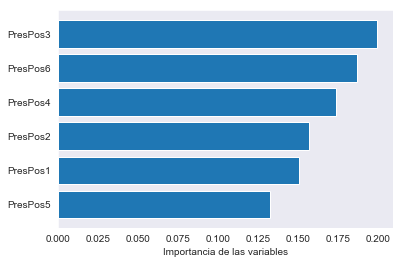

In [117]:
sorted_idx = rf7.feature_importances_.argsort()
plt.barh(X7.columns[sorted_idx], rf7.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 3 se pone al valor óptimo de presión 4, la media del SQR mejora en un 15.35%. 

<a id="8"></a>
### FLO

#### Descriptivo general

In [118]:
display(fln)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,1385,74.32,13.0,4.82,67.33,76.09,82.73,99.58,flo


#### Análisis de presiones

In [119]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Overweight"').groupby('presiones').describe().loc[:, 'sqr']

In [120]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [121]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/fln['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [122]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 023211                     427                 0.31  70.92   
        023321                     374                 0.27  76.17   
        033211                     107                 0.08  67.90   
mejores 133321                       1                 0.00  99.34   
        033321                      55                 0.04  86.35   
        234323                      87                 0.06  85.21   
peores  023421                       2                 0.00  54.29   
        012221                       1                 0.00  66.31   
        133431                      20                 0.01  67.62   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 023211          13.23   4.82  63.89  72.62  79.73  96.50  
        023321          11.88  27.57  70.20  77.77  83.39  99.58  
        033211          13.49  10.43  62.10  69.53  77.40  90.48  
mejores 133321            NaN  99.34  99.34  99.34  99.34  99.34  
        033321           7.95  68.03  81.49  87.83  93.03  98.78  
        234323           7.12  63.94  79.86  85.41  91.36  96.99  
peores  023421          16.62  42.54  48.41  54.29  60.17  66.05  
        012221            NaN  66.31  66.31  66.31  66.31  66.31  
        133431          11.20  47.19  56.59  71.65  75.87  83.30

#### Importancia de los tubos

In [123]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf8 = rfr.fit(X8, y8)

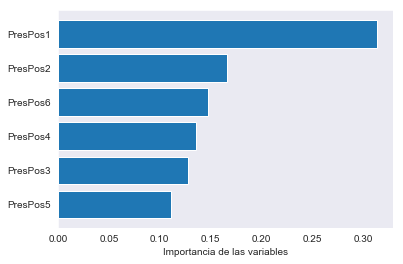

In [124]:
sorted_idx = rf8.feature_importances_.argsort()
plt.barh(X8.columns[sorted_idx], rf8.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 1 se pone al valor óptimo de presión 3, la media del SQR mejora en un 14.62%.

<a id="9"></a>
### FLOb

#### Descriptivo general

In [125]:
display(fls)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,823,67.2,14.71,3.11,58.52,68.74,77.86,99.37,flob


#### Análisis de presiones

In [126]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Lateral" &  IMC_cat == "Obese"').groupby('presiones').describe().loc[:, 'sqr']

In [127]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [128]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/fls['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [129]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 033211                     148                 0.18  67.52   
        123211                     145                 0.18  63.08   
        023321                     117                 0.14  76.64   
mejores 123212                       9                 0.01  91.04   
        000000                       1                 0.00  85.16   
        023321                     117                 0.14  76.64   
peores  335532                      90                 0.11  55.10   
        234432                       2                 0.00  56.97   
        133431                      18                 0.02  59.04   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 033211          15.02   3.11  61.45  70.55  78.17  90.96  
        123211          10.41  32.28  57.29  63.58  70.62  85.73  
        023321          11.74  27.00  71.97  78.78  84.73  97.71  
mejores 123212           4.61  83.73  88.72  90.41  94.00  98.66  
        000000            NaN  85.16  85.16  85.16  85.16  85.16  
        023321          11.74  27.00  71.97  78.78  84.73  97.71  
peores  335532          13.99   5.20  48.34  56.34  65.20  83.75  
        234432          15.17  46.25  51.61  56.97  62.34  67.70  
        133431          22.82  15.92  39.85  58.44  78.56  94.84

#### Importancia de los tubos

In [130]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf9 = rfr.fit(X9, y9)

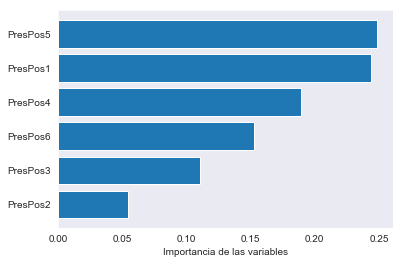

In [131]:
sorted_idx = rf9.feature_importances_.argsort()
plt.barh(X9.columns[sorted_idx], rf9.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 5 se pone al valor óptimo de presión 3, la media del SQR mejora en un 13.79%. Si el tubo 1 se pone al valor óptimo de presión 3, la media del SQR mejora en un 5.34%.

<a id="10"></a>
### FSN

#### Descriptivo general

In [132]:
display(fsb)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,1667,71.44,13.84,0.02,63.28,72.58,80.93,99.58,fsn


#### Análisis de presiones

In [133]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Normal"').groupby('presiones').describe().loc[:, 'sqr']

In [134]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [135]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/fsb['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [136]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 122222                     718                 0.43  73.14   
        122212                     242                 0.15  68.98   
        122221                     196                 0.12  73.82   
mejores 000002                      13                 0.01  88.27   
        120022                       1                 0.00  82.05   
        011111                       6                 0.00  79.93   
peores  030111                       2                 0.00  61.76   
        133331                     146                 0.09  63.56   
        022333                      11                 0.01  63.94   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 122222          12.92   8.12  65.49  74.28  81.11  99.58  
        122212          17.57   0.02  58.00  70.44  81.77  99.45  
        122221          13.65  36.55  64.98  74.22  86.33  94.23  
mejores 000002           3.99  83.16  85.21  87.74  88.81  96.16  
        120022            NaN  82.05  82.05  82.05  82.05  82.05  
        011111          11.65  67.80  70.24  78.20  88.47  95.91  
peores  030111           0.92  61.11  61.44  61.76  62.09  62.42  
        133331          12.27  20.32  57.14  66.33  71.48  89.20  
        022333          15.48  34.41  55.53  59.03  75.14  87.84

#### Importancia de los tubos

In [137]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf10 = rfr.fit(X10, y10)

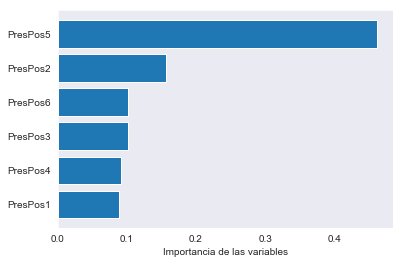

In [138]:
sorted_idx = rf10.feature_importances_.argsort()
plt.barh(X10.columns[sorted_idx], rf10.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 5 se pone al valor óptimo de presión 1, la media del SQR mejora en un 11.58%.

<a id="11"></a>
### FSO

#### Descriptivo general

In [139]:
display(fsn)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,3048,71.77,16.61,0.55,62.62,74.83,84.03,99.72,fso


#### Análisis de presiones

In [140]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Overweight"').groupby('presiones').describe().loc[:, 'sqr']

In [141]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [142]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/fsn['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [143]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 122322                     160                 0.05  74.32   
        123222                      47                 0.02  59.62   
        110302                      17                 0.01  78.03   
mejores 032325                       6                 0.00  89.07   
        123322                       9                 0.00  80.37   
        110302                      17                 0.01  78.03   
peores  111111                       2                 0.00  36.32   
        122222                       8                 0.00  58.26   
        123222                      47                 0.02  59.62   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 122322          12.22  35.27  68.19  76.19  81.84  99.37  
        123222          13.06  19.98  54.10  60.54  67.24  91.85  
        110302           9.66  62.60  70.53  74.64  87.37  95.41  
mejores 032325           9.19  75.88  83.42  89.75  96.05  99.58  
        123322           9.23  64.41  75.76  81.07  87.20  92.39  
        110302           9.66  62.60  70.53  74.64  87.37  95.41  
peores  111111          32.01  13.69  25.00  36.32  47.64  58.95  
        122222          21.16  32.32  39.13  61.65  71.44  92.12  
        123222          13.06  19.98  54.10  60.54  67.24  91.85

#### Importancia de los tubos

In [144]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf11 = rfr.fit(X11, y11)

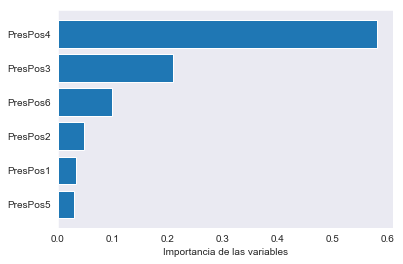

In [145]:
sorted_idx = rf11.feature_importances_.argsort()
plt.barh(X11.columns[sorted_idx], rf11.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 4 se pone al valor óptimo de presión 4, la media del SQR mejora en un 5.37%.

<a id="12"></a>
### FSOb

#### Descriptivo general

In [146]:
display(fss)

,frecuencia absoluta,media,desviación,min,25%,50%,75%,max,categoría
sqr,126,68.46,11.98,8.86,62.02,68.82,77.17,94.57,fsob


#### Análisis de presiones

In [147]:
presiones_cat = perfiles_sqr.query('sexo == "Female" & posicion == "Supine" &  IMC_cat == "Obese"').groupby('presiones').describe().loc[:, 'sqr']

In [148]:
presiones_cat = presiones_cat.rename({'count':'frecuencia absoluta', 'mean':'media', 'std': 'desviación'}, axis='columns').round(2)
presiones_cat['frecuencia absoluta'] = presiones_cat['frecuencia absoluta'].astype('int')
presiones_comunes = presiones_cat.sort_values(by='frecuencia absoluta', ascending=False).head(3)
presiones_comunes['tipo'] = 'comunes'
presiones_top = presiones_cat.sort_values(by='media', ascending=False).head(3)
presiones_top['tipo'] = 'mejores'
presiones_bottom = presiones_cat.sort_values(by='media', ascending=True).head(3)
presiones_bottom['tipo'] = 'peores'

In [149]:
presiones_cat = presiones_comunes.append(presiones_top).append(presiones_bottom)
presiones_cat.reset_index(level=0, inplace=True)
presiones_cat['frecuencia relativa'] = round(presiones_cat['frecuencia absoluta']/fss['frecuencia absoluta'].values, 2)
presiones_cat = presiones_cat[cols]

In [150]:
display(presiones_cat.set_index(['tipo', 'presiones']))

frecuencia absoluta  frecuencia relativa  media  \
tipo    presiones                                                    
comunes 555555                      65                 0.52  64.91   
        122322                      16                 0.13  77.71   
        010022                      13                 0.10  74.27   
mejores 122322                      16                 0.13  77.71   
        010022                      13                 0.10  74.27   
        123332                      12                 0.10  71.95   
peores  010002                       2                 0.02  44.55   
        555555                      65                 0.52  64.91   
        012322                       5                 0.04  67.29   

                   desviación    min    25%    50%    75%    max  
tipo    presiones                                                 
comunes 555555          12.10   8.86  59.24  67.24  70.24  91.71  
        122322           7.34  63.20  74.49  78.40  80.10  94.57  
        010022           8.60  61.01  70.78  73.34  78.84  90.86  
mejores 122322           7.34  63.20  74.49  78.40  80.10  94.57  
        010022           8.60  61.01  70.78  73.34  78.84  90.86  
        123332          12.11  51.65  64.88  70.73  81.84  89.81  
peores  010002           2.80  42.57  43.56  44.55  45.54  46.53  
        555555          12.10   8.86  59.24  67.24  70.24  91.71  
        012322           8.99  55.48  62.50  66.53  73.85  78.10

#### Importancia de los tubos

In [151]:
## Comenzamos a hacer rf
params = {'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 10,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 300,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

rfr = RandomForestRegressor(**params)
rf12 = rfr.fit(X12, y12)

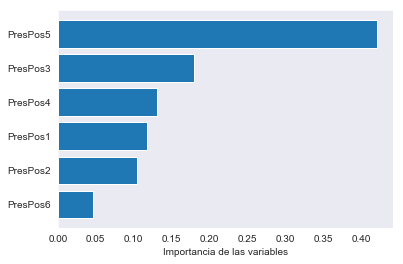

In [152]:
sorted_idx = rf12.feature_importances_.argsort()
plt.barh(X12.columns[sorted_idx], rf12.feature_importances_[sorted_idx])
plt.xlabel("Importancia de las variables");

En esta categoría, si el tubo 5 se pone al valor óptimo de presión 3, la media del SQR mejora en un 7.35%.

In [153]:
#Guardar en HTML sin codigo --TemplateExporter.exclude_input=True --no-input
!jupyter nbconvert Descriptivo_uni_bi.ipynb --to html --log-level WARN --TemplateExporter.exclude_input=True 